In [19]:
import cv2
import numpy as np
from matplotlib import pyplot as plt



def safe_fit_ellipse(cnt):
    if len(cnt) < 5:
        return None
    try:
        ellipse = cv2.fitEllipse(cnt)
        (cx, cy), (ax1, ax2), angle = ellipse
        if (
            np.isnan(cx) or np.isnan(cy) or
            np.isnan(ax1) or np.isnan(ax2) or
            np.isnan(angle)
        ):
            return None
        return ellipse
    except cv2.error:
        return None


def ellipse_area_score(cnt, ellipse):
    (cx, cy), (ax1, ax2), angle = ellipse
    ellipse_area = np.pi * (ax1 / 2.0) * (ax2 / 2.0)
    contour_area = cv2.contourArea(cnt)

    if contour_area <= 0 or ellipse_area <= 0:
        return 0.0

    return min(contour_area, ellipse_area) / max(contour_area, ellipse_area)


def ellipse_geometric_score(cnt, ellipse):
    # Lower is better; convert to similarity score later
    (cx, cy), (ax1, ax2), angle = ellipse
    angle_rad = np.deg2rad(angle)

    R = np.array([
        [np.cos(angle_rad), -np.sin(angle_rad)],
        [np.sin(angle_rad),  np.cos(angle_rad)]
    ])

    errors = []
    for p in cnt.reshape(-1, 2):
        v = p - np.array([cx, cy])
        v_rot = R.T @ v
        x, y = v_rot
        value = (x / (ax1 / 2))**2 + (y / (ax2 / 2))**2
        errors.append(abs(value - 1))

    avg_err = np.mean(errors)
    return 1.0 / (1.0 + avg_err)  # convert to similarity: high = good


def detect_best_ellipse(binary_img):
    '''outputs resulting_image, best_ellipse, best_score'''
    # Normalize input
    if binary_img.dtype != np.uint8:
        img = (binary_img > 0).astype(np.uint8) * 255
    else:
        img = binary_img.copy()

    contours, _ = cv2.findContours(img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    best_score = -1
    best_ellipse = None

    for cnt in contours:
        ellipse = safe_fit_ellipse(cnt)
        if ellipse is None:
            continue

        area_score = ellipse_area_score(cnt, ellipse)      # [0, 1]
        geom_score = ellipse_geometric_score(cnt, ellipse) # ~[0, 1]

        final_score = 0.5 * area_score + 0.5 * geom_score

        if final_score > best_score:
            best_score = final_score
            best_ellipse = ellipse

    # Draw result
    result = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)

    if best_ellipse is not None:
        cv2.ellipse(result, best_ellipse, (0, 255, 0), 2)

    return result, best_ellipse, best_score


In [49]:
def write_data(image, detection, score):
    if not detection is None:
        print("writing")
        cv2.putText(image, f"Score: {score :.2f} Height: {detection[1][0] :.2f}", (50, 80), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 4)
    else:
        cv2.putText(image, "No Detection", (50, 80), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 4)
    return image

In [50]:
import cv2
import numpy as np

cap = cv2.VideoCapture('./downstairs1.mp4')
ret, current_frame = cap.read()
if not ret:
    raise RuntimeError("Could not read video")

previous_frame = current_frame.copy()

h, w = current_frame.shape[:2]
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
video = cv2.VideoWriter("diff_video.mp4", fourcc, 10, (w, h))

i = 0
heights = []
scores = []
while True:
    ret, current_frame = cap.read()
    if not ret or i >= 200:
        break

    i += 1
    print("processing frame", i, end="\r")

    current_gray = cv2.cvtColor(current_frame, cv2.COLOR_BGR2GRAY)
    prev_gray = cv2.cvtColor(previous_frame, cv2.COLOR_BGR2GRAY)
    
    current_lab = cv2.cvtColor(current_frame, cv2.COLOR_BGR2Lab)
    current_lab[:, :, 0] = 0.5
    prev_lab = cv2.cvtColor(previous_frame, cv2.COLOR_BGR2Lab)
    prev_lab[:, :, 0] = 0.5

    frame_diff = cv2.absdiff(current_lab, prev_lab)
    frame_diff[:, :, 0] = 0.5
    # diff_rgb = np.stack([frame_diff]*3, axis=-1)
    
    pixels = np.where(np.sum(frame_diff, axis=-1) > 10)
    threshold_arr = np.zeros((frame_diff.shape[0], frame_diff.shape[1]), dtype=np.uint8)
    threshold_arr[pixels] = np.sum(frame_diff, axis=-1)[pixels[0], pixels[1]]
    # threshold_arr = cv2.GaussianBlur(threshold_arr, (9, 9), 2)
    
    circled_frame, detection, score = detect_best_ellipse(threshold_arr)
    if not detection is None:
        heights.append(detection[1][0])
        scores.append(score)
    else:
        heights.append(0)
        scores.append(0)
    # circled_frame = np.stack((circled_frame, circled_frame, circled_frame), axis=-1)
    
    circled_frame = write_data(circled_frame, detection, score)
    video.write(circled_frame)

    previous_frame = current_frame.copy()

video.release()
cap.release()


writinging frame 1
writinging frame 2
writinging frame 3


/tmp/ipykernel_2653241/2423121562.py:50: RuntimeWarning: divide by zero encountered in scalar divide
  value = (x / (ax1 / 2))**2 + (y / (ax2 / 2))**2
/tmp/ipykernel_2653241/2423121562.py:50: RuntimeWarning: invalid value encountered in scalar divide
  value = (x / (ax1 / 2))**2 + (y / (ax2 / 2))**2


writing
writinging frame 5
writinging frame 6
writinging frame 7
writinging frame 8
writinging frame 9
writinging frame 10
writinging frame 11
writinging frame 12
writinging frame 13
writinging frame 14
writinging frame 15
writinging frame 16
writinging frame 17
writinging frame 18
writinging frame 19
writinging frame 20
writinging frame 21
writinging frame 22
writinging frame 23
writinging frame 24
writinging frame 25
writinging frame 26
writinging frame 27
writinging frame 28
writinging frame 29
writinging frame 30
writinging frame 31
writinging frame 32
writinging frame 33
writinging frame 34
writinging frame 35
writinging frame 36
writinging frame 37
writinging frame 38
writinging frame 39
writinging frame 40
writinging frame 41
writinging frame 42
writinging frame 43
writinging frame 44
writinging frame 45
writinging frame 46
writinging frame 47
writinging frame 48
writinging frame 49
writinging frame 50
writinging frame 51
writinging frame 52
writinging frame 53
writinging frame 

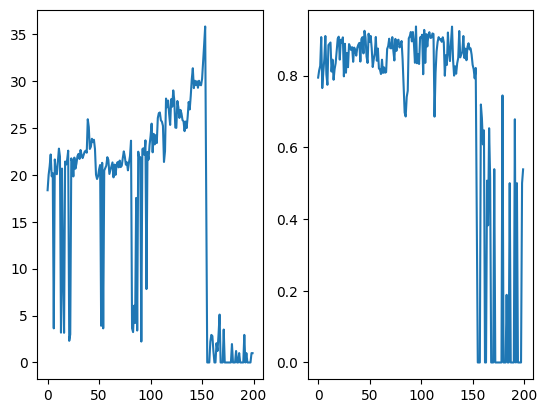

In [51]:
fig, axes = plt.subplots(1, 2)
axes[0].plot(list(range(len(heights))), heights)
axes[1].plot(list(range(len(scores))), scores)

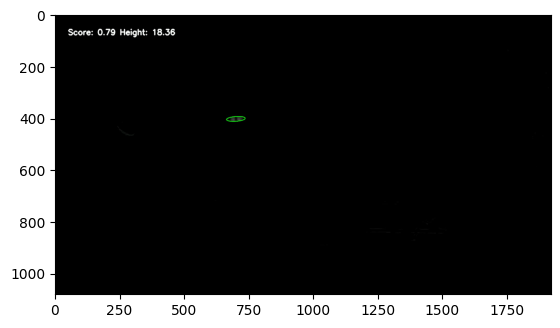

In [52]:
cap = cv2.VideoCapture("./diff_video.mp4")
ret, frame = cap.read()
plt.imshow(frame)